In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#import the libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Data Visualization 
import seaborn as sns  #Python library for Vidualization

# ANALYSIS & PRE PROCESSING

In [20]:
users = pd.read_csv('users.csv')
print(users.columns)

events = pd.read_csv('events.csv')
print(events.columns)

articles = pd.read_csv('articles.csv')
print(articles.columns)

Index(['user_id', 'os', 'deviceType', 'city', 'country', 'region',
       'active_time', 'number_events', 'number_of_articles_visited',
       'cluster'],
      dtype='object')
Index(['event_id', 'active_time', 'user_id', 'time', 'url', 'document_id'], dtype='object')
Index(['document_id', 'title', 'category', 'publish_time', 'number_views',
       'keywords', 'author'],
      dtype='object')


In [21]:
print(len(users.os.unique()))
print(len(users.deviceType.unique()))
print(len(users.city.unique()))
print(len(users.country.unique()))
print(len(users.region.unique()))

7
3
122
16
39


In [23]:
import pandas as pd
from sklearn import preprocessing

x = users[['active_time', 'number_events','number_of_articles_visited']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
users[['active_time', 'number_events','number_of_articles_visited']] = x_scaled

In [25]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
trained_enc = enc.fit(users[['os', 'deviceType', 'city', 'country', 'region']])
def encode_user(user):
    one_hot_users = trained_enc.transform(user[['os', 'deviceType', 'city', 'country', 'region']])
    one_hot_users = pd.DataFrame(one_hot_users.toarray(), columns=trained_enc.get_feature_names())
    one_hot_users[['active_time', 'number_events','number_of_articles_visited']] = user[['active_time', 'number_events','number_of_articles_visited']].values
    return one_hot_users


In [26]:
from sklearn.cluster import KMeans
one_hot_users = encode_user(users)
wcss=[]

for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(one_hot_users)
    wcss.append(kmeans.inertia_)

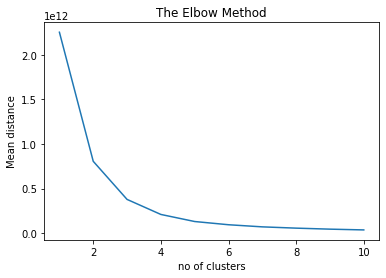

In [6]:
#without normalization
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('Mean distance')
plt.show()

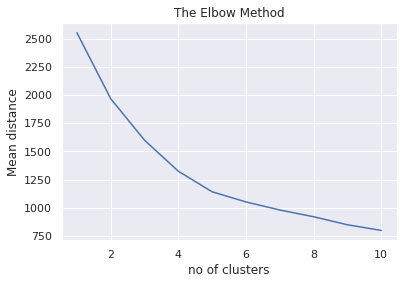

In [27]:
#with normalization
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('Mean distance')
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(one_hot_users)

PCA(n_components=3)

In [30]:
print(pca.explained_variance_)

[0.65991953 0.49616892 0.36846593]


In [31]:
one_hot_users_pca = pca.transform(one_hot_users)
print("original shape:   ", one_hot_users.shape)
print("transformed shape:", one_hot_users_pca.shape)

original shape:    (1000, 190)
transformed shape: (1000, 3)


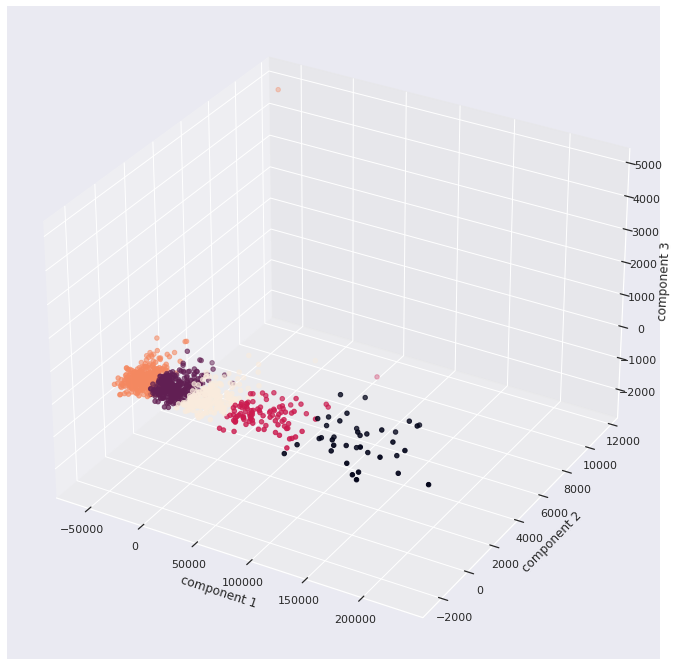

In [11]:
#without normalization
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(one_hot_users_pca[:,0], one_hot_users_pca[:,1], one_hot_users_pca[:,2], c=users.cluster, marker='o')
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')

plt.show()

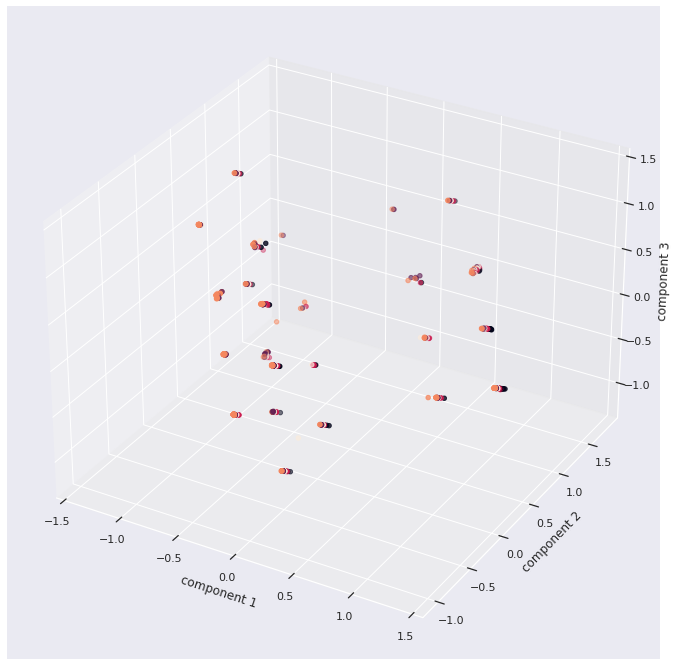

In [32]:
#with normalization
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(one_hot_users_pca[:,0], one_hot_users_pca[:,1], one_hot_users_pca[:,2], c=users.cluster, marker='o')
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')

plt.show()

# MODELING

In [33]:
from collections import Counter
#Model Build
kmeansmodel = KMeans(n_clusters= 5, init='k-means++', random_state=0)
kmeansmodel.fit(encode_user(users))

def cluster_recomendation(user, n_recomendations):
    user_cluster = kmeansmodel.predict(encode_user(user))
    cluster_users = users[users.cluster == user_cluster[0]]
    
    articles_id = events[events.user_id.isin(cluster_users.user_id)]
    c = Counter(articles_id.document_id.dropna())
    articles_id = [i[0] for i in c.most_common(n_recomendations)]
    recomended_articles = articles[articles.document_id.isin(articles_id)].index
    return recomended_articles

In [34]:
cluster_recomendation(users.iloc[[301]], 5)

Int64Index([1292, 8047, 8974, 14671, 19243], dtype='int64')

# EVALUATION

In [35]:
y_kmeans= kmeansmodel.predict(encode_user(users))
users['cluster'] = y_kmeans

In [36]:
train=users.sample(frac=0.75)
test=users.drop(train.index)

In [37]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

def evaluate(train, test, batch_size):
    print("Batch size "+str(batch_size))
    cluster_recomendations = {}
    for cluster in train.cluster.unique():
        cluster_users = train[train.cluster == cluster]
        articles_id = events[events.user_id.isin(cluster_users.user_id)]
        c = Counter(articles_id.document_id.dropna())
        top_articles_id = [i[0] for i in c.most_common(batch_size)]
        recomended_articles = articles[articles.document_id.isin(top_articles_id)].index
        cluster_recomendations[cluster] = recomended_articles
    
    train_eval = []
    test_eval = []
    for i, user in train.iterrows():
        user_cluster = user.cluster
        user_articles_id = events[events.user_id == user.user_id].document_id.dropna().unique()
        user_articles = articles[articles.document_id.isin(user_articles_id)].index
        
        train_eval.append(len(intersection(user_articles, cluster_recomendations[user_cluster])))
        
    print("Training eval "+str(np.mean(train_eval)/batch_size))
    for i, user in test.iterrows():
        user_cluster = user.cluster
        user_articles_id = events[events.user_id == user.user_id].document_id.dropna().unique()
        user_articles = articles[articles.document_id.isin(user_articles_id)].index
        
        test_eval.append(len(intersection(user_articles, cluster_recomendations[user_cluster])))
    
    print("Testing eval "+str(np.mean(test_eval)/batch_size))

In [17]:
#without normalization
evaluate(train,test, 30)
evaluate(train,test, 10)
evaluate(train,test, 3)
evaluate(train,test, 1)

Batch size 30
Training eval 0.5740444444444445
Testing eval 0.5652
Batch size 10
Training eval 0.5961333333333333
Testing eval 0.5876
Batch size 3
Training eval 0.5444444444444444
Testing eval 0.5493333333333333
Batch size 1
Training eval 0.3586666666666667
Testing eval 0.356


In [38]:
#with normalization
evaluate(train,test, 30)
evaluate(train,test, 10)
evaluate(train,test, 3)
evaluate(train,test, 1)

Batch size 30
Training eval 0.5779111111111112
Testing eval 0.5596
Batch size 10
Training eval 0.5912
Testing eval 0.5896
Batch size 3
Training eval 0.4977777777777778
Testing eval 0.5253333333333333
Batch size 1
Training eval 0.448
Testing eval 0.452
